## Trabalho de conclusão de curso - KIRC
#### Especialização em engenharia de software para aplicações de ciência de dados  
**Nome aluna:** Grace dos Santos Feijó              
**Nome orientadora:** Profa. Dra. Mariana R. Mendonza  

**Título: Explorando o aprendizado de máquina explicável para predizer fatores genéticos relacionados à sobrevivência ao câncer a partir de dados transcriptômicos**


#### Importar libraries

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg") # non-interactive backend
%matplotlib inline

import shap
import umap.umap_ as umap

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import ( accuracy_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
from scipy.stats import mannwhitneyu

from lifelines.utils import concordance_index

#### Importar e unir datasets KIRC

In [56]:
# Dataset Genes - KIRC
file_path = "TCGA-KIRC.star_fpkm-uq.tsv"
df = pd.read_csv(file_path, sep='\t', header=0, index_col=0)  # primeira coluna = gene
# Transpose (linhas = pacientes, colunas = genes)
df_transposed = df.transpose().reset_index()
df_transposed = df_transposed.rename(columns={"index": "sample"})
# print(df_transposed.head())

# Dataset Fenótipos - KIRC
file_path2: str = "TCGA-KIRC.clinical.tsv"
df_phenotype = pd.read_csv(file_path2, sep='\t', header=0, index_col=0)
# print(df_phenotype.head())

# Dataset Survival - KIRC
file_path3 = "TCGA-KIRC.survival.tsv"
df_survival = pd.read_csv(file_path3, sep='\t', header=0, index_col=0)
# print(df_survival)

# Merge datasets
df_merged1 = pd.merge(df_transposed, df_phenotype, on="sample", how="inner")
df_merged2 = pd.merge(df_merged1, df_survival, on="sample", how="inner")
# print(df_merged2)

# Merged only with OS information
df_survival = df_survival.reset_index()
df_merged_OS = df_transposed.merge(df_survival[["sample", "OS"]], on="sample", how="left")

# Merged with OS information, gender.demographic and tissue_type.samples 
# Leave only tissue_type.samples as ´Tumor`
df_phenotype = df_phenotype.reset_index()
df_merged_OS_phenotype = df_merged_OS.merge(
    df_phenotype[['sample', 'gender.demographic', 'tissue_type.samples']], on='sample', how='left'
).query("`tissue_type.samples` != 'Normal'").dropna() # drop null values

# Valores faltantes
#print(df_merged_OS_phenotype.isnull().sum().sort_values(ascending=False).head())
#print("Total missing values:", df_merged_OS_phenotype.isnull().sum().sum()) # total missing values

# Replace gender by numerical variables
df_merged_OS_phenotype['gender.demographic'] = (df_merged_OS_phenotype['gender.demographic'] .replace({'female': 1, 'male': 0}) .astype(int) )
print(df_merged_OS_phenotype.head()) 

             sample  ENSG00000000003.15  ENSG00000000005.6  \
0  TCGA-CW-5584-01A            3.672629           0.515511   
1  TCGA-CZ-5984-01A            4.650661           0.262193   
2  TCGA-B0-4841-01A            3.516595           1.539432   
3  TCGA-B0-4700-01A            3.688147           0.268195   
4  TCGA-CJ-4905-01A            3.553090           0.418028   

   ENSG00000000419.13  ENSG00000000457.14  ENSG00000000460.17  \
0            4.045207            1.129481            0.643117   
1            4.801516            1.339879            0.853996   
2            4.162331            1.336226            0.457542   
3            4.805452            1.365804            0.758388   
4            4.159984            1.473267            0.724738   

   ENSG00000000938.13  ENSG00000000971.16  ENSG00000001036.14  \
0            2.877568            2.191184            4.044036   
1            2.506373            4.644981            4.160670   
2            3.212554            3.091548

#### Estatísticas descritivas

In [57]:
# Estatísticas descritivas gerais
# Remover as colunas 'sample' e 'tissue_type.samples', change to log2 
desc = df_merged_OS_phenotype.drop(columns=['sample', 'tissue_type.samples'])
desc_log = np.log2(desc + 1)
# print(desc_log.head())

# Count FEM (1)/MAC(0), OS DEAD(1)/ALIVE(O), Number of variables, total sample
os_count = desc_log['OS'].value_counts()
print(os_count)
gender_count = desc_log['gender.demographic'].value_counts()
print(gender_count)
col_row = pd.DataFrame(desc_log)
rows, columns = df.shape
print(f"Rows: {rows}, Columns: {columns}")

# Média, mediana e desvio padrão por gene
mean_expr = desc_log.mean()
median_expr = desc_log.median()
std_expr = desc_log.std()
print(f"Média: {mean_expr.head()}")
print(f"Mediana: {median_expr.head()}")
print(f"Desvio padrão: {median_expr.head()}")

OS
0.0    361
1.0    173
Name: count, dtype: int64
gender.demographic
0.0    349
1.0    185
Name: count, dtype: int64
Rows: 60660, Columns: 610
Média: ENSG00000000003.15    2.226715
ENSG00000000005.6     0.480486
ENSG00000000419.13    2.477170
ENSG00000000457.14    1.291830
ENSG00000000460.17    0.785391
dtype: float64
Mediana: ENSG00000000003.15    2.221229
ENSG00000000005.6     0.308429
ENSG00000000419.13    2.469663
ENSG00000000457.14    1.301210
ENSG00000000460.17    0.777666
dtype: float64
Desvio padrão: ENSG00000000003.15    2.221229
ENSG00000000005.6     0.308429
ENSG00000000419.13    2.469663
ENSG00000000457.14    1.301210
ENSG00000000460.17    0.777666
dtype: float64


In [58]:
# Teste de Shapiro-Wilk
statistica, p_valor = stats.shapiro(desc_log) 
print(f"Estatística do teste: {statistica}")
print(f"p-valor: {p_valor}")

# Interpretação do resultado
alpha = 0.05
if p_valor > alpha:
    print("Não podemos rejeitar a hipótese nula: os dados parecem vir de uma distribuição normal.")
else:
    print("Rejeitamos a hipótese nula: os dados não parecem vir de uma distribuição normal.")

Estatística do teste: 0.6954660326141998
p-valor: 1.8471818407192463e-187
Rejeitamos a hipótese nula: os dados não parecem vir de uma distribuição normal.


Dados parecem não seguir uma distribuição normal, apesar da transformação de log (usar spearman)

#### Ditribuição - gráfico

Text(0, 0.5, 'Frequência')

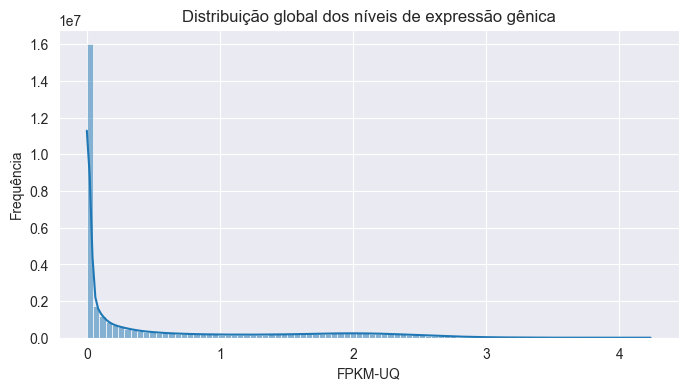

In [59]:
# Distribuição global de expressão (todas as amostras)
plt.figure(figsize=(8, 4))
sns.histplot(desc_log.values.flatten(), bins=90, kde=True)
plt.title("Distribuição global dos níveis de expressão gênica")
plt.xlabel("FPKM-UQ")
plt.ylabel("Frequência")

#### Genes com maior variância e p-value entre OS 1 e 0 (STD)

Desvio padrão é sensível aos outliers

Index(['ENSG00000129824.16', 'ENSG00000226278.1', 'ENSG00000171564.12',
       'ENSG00000173432.12', 'ENSG00000171557.17', 'ENSG00000157005.4',
       'ENSG00000067048.17', 'ENSG00000164434.12', 'ENSG00000171560.16',
       'ENSG00000174358.16', 'ENSG00000197901.12', 'ENSG00000187048.13',
       'ENSG00000129988.6', 'ENSG00000188373.5', 'ENSG00000157765.13',
       'ENSG00000124107.5', 'ENSG00000115386.6', 'ENSG00000143839.15',
       'ENSG00000138207.14', 'ENSG00000229028.2'],
      dtype='object')


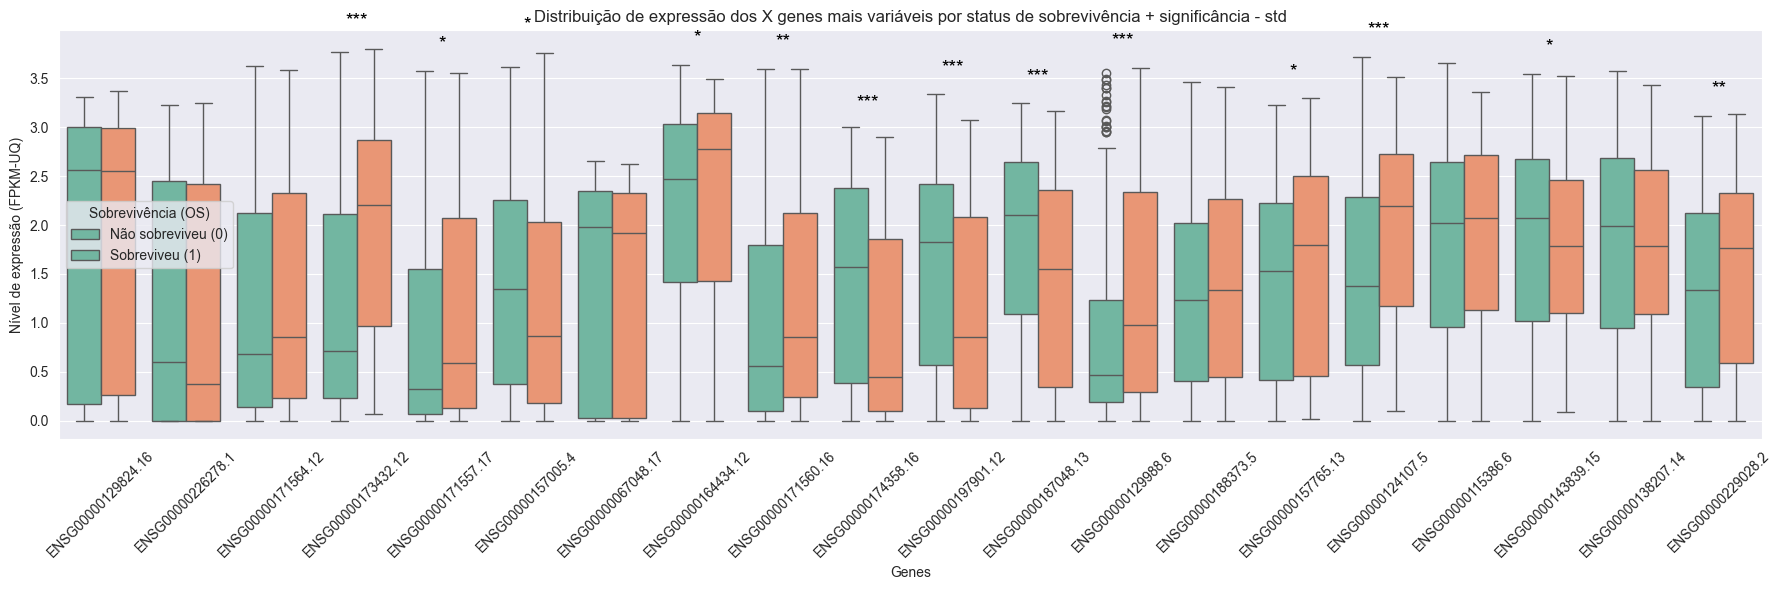

In [62]:
#Análises - Desvio Padrão
#Calcular variabilidade dos genes 
gene_variability = desc_log.std().sort_values(ascending=False) #USANDO DESVIO PADRÃO

# Selecionar os X genes mais variáveis
top_genes_std = gene_variability.head(20).index
print(top_genes_std)

# Modificar dataframe para formato longo - seaborn
df_melted = desc_log.melt(id_vars=['OS'], value_vars= top_genes_std,var_name='Gene', value_name='Expressão')

# Significância
# Calcular p-valores (Mann–Whitney U) para cada gene
p_values = {}
for gene in top_genes_std:
    group0 = desc_log[desc_log['OS'] == 0][gene]
    group1 = desc_log[desc_log['OS'] == 1][gene]
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    p_values[gene] = p
pval_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])

# Criar o boxplot
plt.figure(figsize=(18, 6))
ax = sns.boxplot(data=df_melted, x='Gene', y='Expressão', hue='OS', palette='Set2')

# Asteriscos conforme nível de significância ente grupos (* p < 0.05, ** p < 0.01, *** p < 0.001)
y_max = df_melted.groupby('Gene')['Expressão'].max()
for i, gene in enumerate(top_genes_std):
    p = pval_df.loc[gene, 'p_value']
    if p < 0.05:
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        else:
            sig = '*'
        y = y_max[gene] * 1.05  # posição vertical do texto
        ax.text(i, y, sig, ha='center', va='bottom', color='black', fontsize=14)

# Gráfico
plt.title("Distribuição de expressão dos X genes mais variáveis por status de sobrevivência + significância - std")
plt.xlabel("Genes")
plt.ylabel("Nível de expressão (FPKM-UQ)")
plt.xticks(rotation=45)
plt.legend(title="Sobrevivência (OS)", labels=["Não sobreviveu (0)", "Sobreviveu (1)"])
plt.tight_layout()
plt.show()


#### Genes com maior variância e p-value entre OS 1 e 0 (quartis)

Usar o intervalo interquartil é menos sensível aos outliers

Index(['ENSG00000129824.16', 'ENSG00000226278.1', 'ENSG00000067048.17',
       'ENSG00000173432.12', 'ENSG00000171564.12', 'ENSG00000197901.12',
       'ENSG00000134184.13', 'ENSG00000174358.16', 'ENSG00000198692.10',
       'ENSG00000157765.13', 'ENSG00000187048.13', 'ENSG00000157005.4',
       'ENSG00000229028.2', 'ENSG00000213058.3', 'ENSG00000124107.5',
       'ENSG00000012817.16', 'ENSG00000007062.12', 'ENSG00000156395.13',
       'ENSG00000135447.17', 'ENSG00000148702.15'],
      dtype='object')


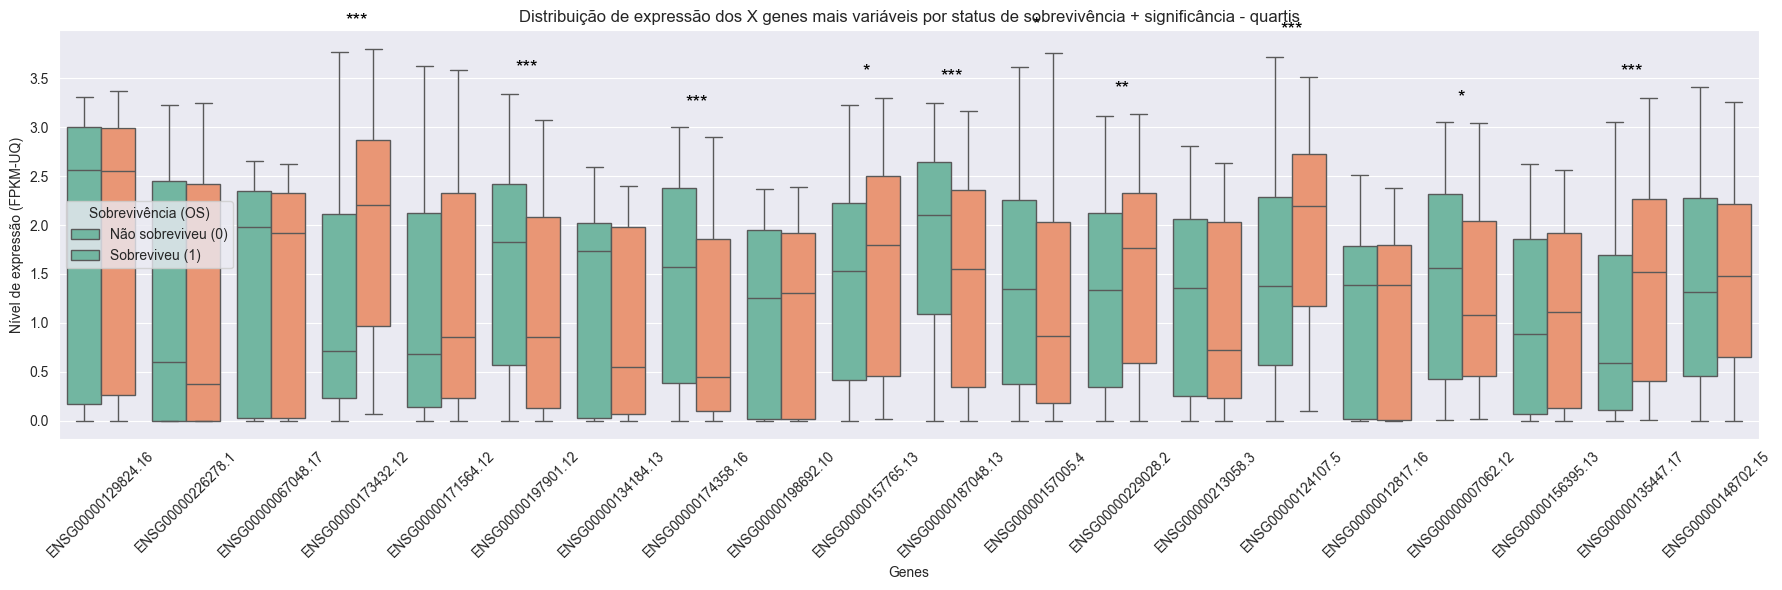

In [63]:
# USANDO QUARTIS
# Calcular variabilidade dos genes 
gene_variability2 = (desc_log.quantile(0.75) - desc_log.quantile(0.25)).sort_values(ascending=False)  #USANDO QUARTIS

# Selecionar os X genes mais variáveis
top_genes_quartis = gene_variability2.head(20).index
print(top_genes_quartis)

# "Derreter" o dataframe para formato longo - seaborn
df_melted = desc_log.melt(id_vars=['OS'], value_vars=top_genes_quartis, var_name='Gene', value_name='Expressão')

# Significância
# Calcular p-valores (Mann–Whitney U) para cada gene
p_values = {}
for gene in top_genes_quartis:
    group0 = desc_log[desc_log['OS'] == 0][gene]
    group1 = desc_log[desc_log['OS'] == 1][gene]
    stat, p = mannwhitneyu(group0, group1, alternative='two-sided')
    p_values[gene] = p
pval_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value'])

# Criar o boxplot
plt.figure(figsize=(18, 6))
ax = sns.boxplot(data=df_melted, x='Gene', y='Expressão', hue='OS', palette='Set2')

# Adicionar asteriscos conforme nível de significância (* p < 0.05, ** p < 0.01, *** p < 0.001)
y_max = df_melted.groupby('Gene')['Expressão'].max()
for i, gene in enumerate(top_genes_quartis):
    p = pval_df.loc[gene, 'p_value']
    if p < 0.05:
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        else:
            sig = '*'
        y = y_max[gene] * 1.05  # posição vertical do texto
        ax.text(i, y, sig, ha='center', va='bottom', color='black', fontsize=14)

# Gráfico
plt.title("Distribuição de expressão dos X genes mais variáveis por status de sobrevivência + significância - quartis")
plt.xlabel("Genes")
plt.ylabel("Nível de expressão (FPKM-UQ)")
plt.xticks(rotation=45)
plt.legend(title="Sobrevivência (OS)", labels=["Não sobreviveu (0)", "Sobreviveu (1)"])
plt.tight_layout()
plt.show()


Avaliar função biológica dos genes com diferença significativa (p<0,05) entre OS 1 e 0

#### Retirar 90% dos genes menos variantes usando o intervalo interquartil

In [64]:
# Copy Dataset
df_genes = desc_log.copy()

# Only genes
meta_cols = ['OS', 'gender.demographic'] 
gene_cols = [c for c in df_genes.columns if c not in meta_cols]
desc = df_genes[gene_cols]

# Variability com base no intervalo interquartil (IQR)
gene_variability_iqr = desc.quantile(0.75) - desc.quantile(0.25)

# Ordenar genes pela variabilidade
gene_variability_iqr = gene_variability_iqr.sort_values(ascending=False)

# Selecionar o top 10% mais variáveis 
top_fraction = 0.10  # manter 10%
top_n = int(len(gene_variability_iqr) * top_fraction)
top_genes_iqr = gene_variability_iqr.head(top_n).index

# Filtrar o dataframe para manter apenas os genes selecionados
df_reduced = pd.concat([df_genes[meta_cols], desc[top_genes_iqr]], axis=1)

# Mostrar o resultado
print(f"Genes totais antes: {len(gene_cols)}")
print(f"Genes mantidos (top X% mais variáveis): {len(top_genes_iqr)}")
print(f"Redução de: {(1 - len(top_genes_iqr)/len(gene_cols)) * 100:.1f}%")


Genes totais antes: 60660
Genes mantidos (top X% mais variáveis): 6066
Redução de: 90.0%


#### Correlação - X genes com maior variância

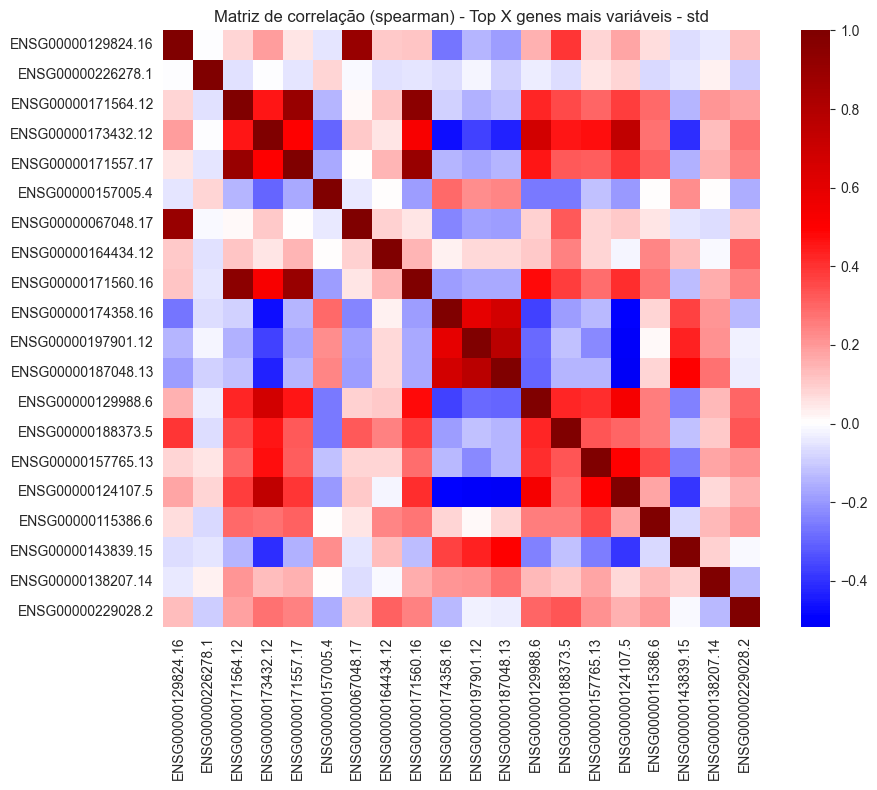

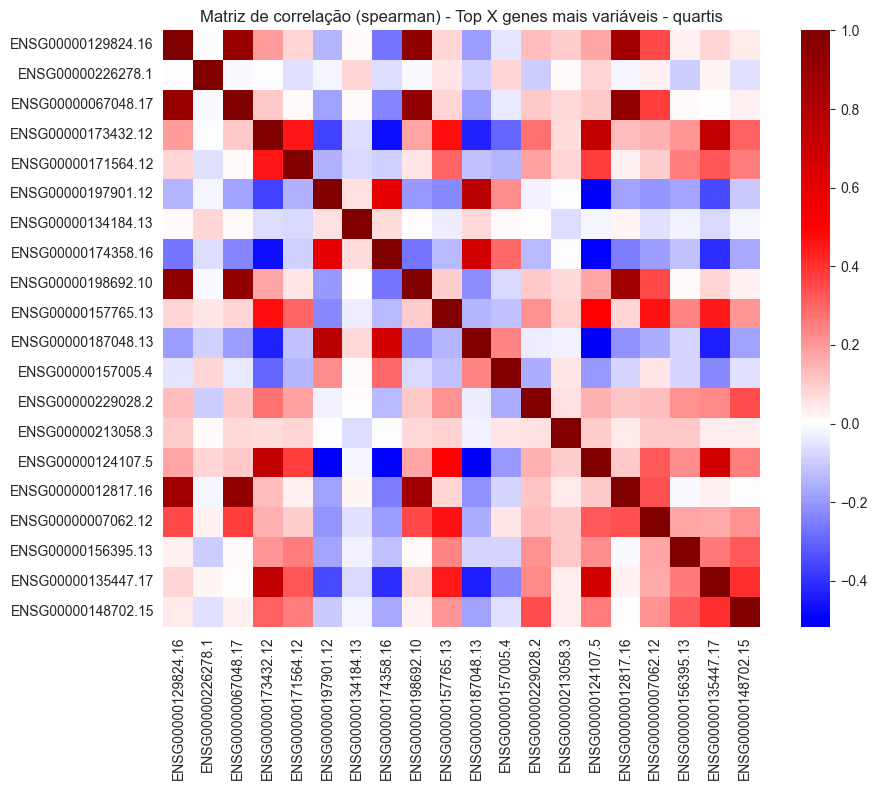

In [65]:
#Correlação top genes std
corr_std = desc_log[top_genes_std].corr(method='spearman') #usando spearman pq os dados não são lineares
plt.figure(figsize=(10, 8))
sns.heatmap(corr_std, cmap="seismic", center=0, annot=False, square=True)
plt.title("Matriz de correlação (spearman) - Top X genes mais variáveis - std")
plt.tight_layout()
plt.show()

#Correlação top genes quartis
corr_quartis = desc_log[top_genes_quartis].corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(corr_quartis, cmap="seismic", center=0, annot=False, square=True)
plt.title("Matriz de correlação (spearman) - Top X genes mais variáveis - quartis")
plt.tight_layout()
plt.show()

#### Correlação de spearman para retirar genes altamente correlacionados

In [68]:
# Isolar apenas os genes (sem OS ou metadados)
gene_data = df_reduced.drop(columns=meta_cols, errors='ignore')

# Calcular matriz de correlação de Spearman
corr_matrix = gene_data.corr(method='spearman')

# Limite de correlação alta (ρ > 0.9)
threshold = 0.9

# Triângulo superior da matriz (para evitar duplicação)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identificar genes redundantes
to_drop = [col for col in upper_tri.columns if any(upper_tri[col].abs() > threshold)]

# Remover os genes correlacionados
df_final = df_reduced.drop(columns=to_drop, errors='ignore')

# Contagem
num_genes_before = gene_data.shape[1]
num_genes_after = num_genes_before - len(to_drop)

print("Seleção de atributos por correlação (Spearman)")
print(f"Genes antes: {num_genes_before}")
print(f"Genes removidos: {len(to_drop)} (|ρ| > {threshold})")
print(f"Genes após: {df_final.shape[1] - len(meta_cols)}\n")

print("Genes removidos:", to_drop)


Seleção de atributos por correlação (Spearman)
Genes antes: 6066
Genes removidos: 273 (|ρ| > 0.9)
Genes após: 5793

Genes removidos: ['ENSG00000198692.10', 'ENSG00000012817.16', 'ENSG00000171560.16', 'ENSG00000171557.17', 'ENSG00000067646.12', 'ENSG00000251320.1', 'ENSG00000183878.15', 'ENSG00000114374.13', 'ENSG00000277987.2', 'ENSG00000162365.12', 'ENSG00000131002.12', 'ENSG00000248362.1', 'ENSG00000165246.14', 'ENSG00000224114.1', 'ENSG00000286785.1', 'ENSG00000099725.14', 'ENSG00000236017.8', 'ENSG00000244437.1', 'ENSG00000244649.5', 'ENSG00000211945.2', 'ENSG00000170476.16', 'ENSG00000139329.5', 'ENSG00000211947.2', 'ENSG00000211966.2', 'ENSG00000050628.20', 'ENSG00000211897.9', 'ENSG00000211651.3', 'ENSG00000231881.2', 'ENSG00000211668.2', 'ENSG00000262198.1', 'ENSG00000241351.3', 'ENSG00000211660.3', 'ENSG00000134853.12', 'ENSG00000211653.2', 'ENSG00000211938.2', 'ENSG00000231535.7', 'ENSG00000273824.1', 'ENSG00000243466.1', 'ENSG00000211949.3', 'ENSG00000164265.9', 'ENSG0000023

#### PCA/UMAP/t-SNE - Dimensionalidade

PCA: 99.32% da variância explicada.


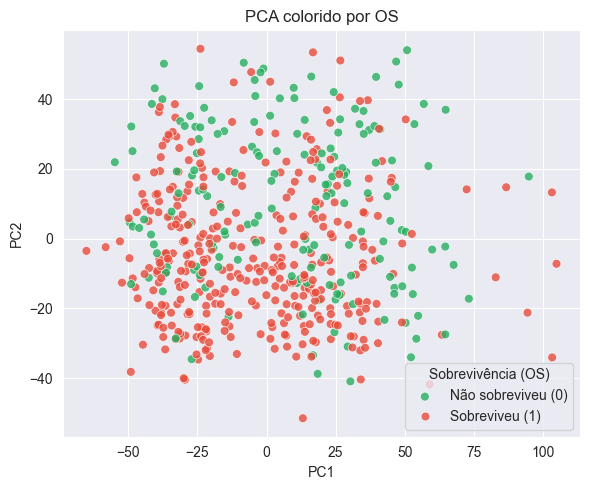

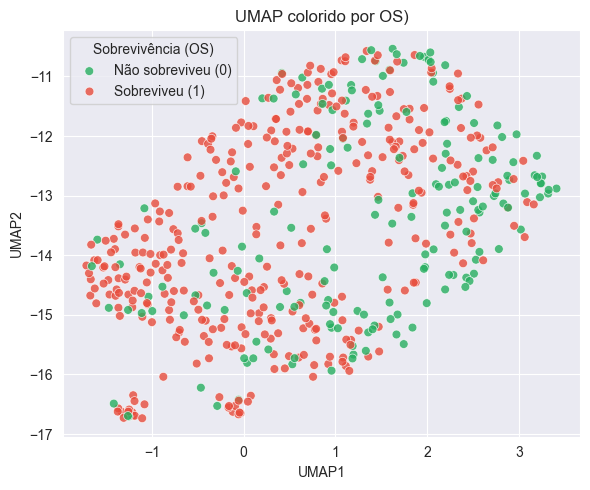

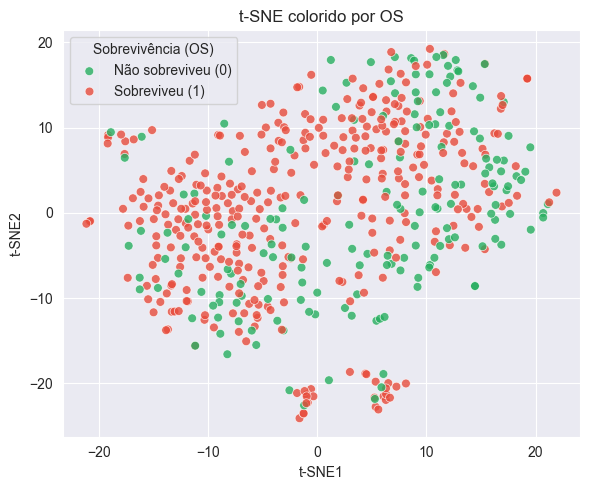

In [70]:
# Feature matrix (X) e target (y)
X = df_final.drop(columns=['gender.demographic', 'OS']) #apenas genes
y = df_final['OS']

# Padronização e PCA - linear
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=500)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA: {pca.explained_variance_ratio_.sum():.2%} da variância explicada.")

plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette={0: "#E74C3C", 1: "#27AE60"}, s=40, alpha=0.8)
plt.title("PCA colorido por OS")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Sobrevivência (OS)", labels=["Não sobreviveu (0)", "Sobreviveu (1)"])
plt.tight_layout()
plt.show()

#UMAP - não linear
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_pca)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette={0: "#E74C3C", 1: "#27AE60"}, s=40, alpha=0.8)
plt.title("UMAP colorido por OS)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(title="Sobrevivência (OS)", labels=["Não sobreviveu (0)", "Sobreviveu (1)"])
plt.tight_layout()
plt.show()

# t-SNE - não linear 
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_pca)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette={0: "#E74C3C", 1: "#27AE60"}, s=40, alpha=0.8)
plt.title("t-SNE colorido por OS")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.legend(title="Sobrevivência (OS)", labels=["Não sobreviveu (0)", "Sobreviveu (1)"])
plt.tight_layout()
plt.show()

#### Random Forest + SHAP 

Amostras: 534, Genes (features): 5793
Treino: (373, 5793), Teste: (161, 5793)

Avaliação no conjunto de teste (70/30)
AUC-ROC: 0.7682
AUC-PR : 0.6651
Acurácia: 0.7516
Sensibilidade (Recall): 0.3654
Especificidade: 0.9358
C-Index: 0.7682


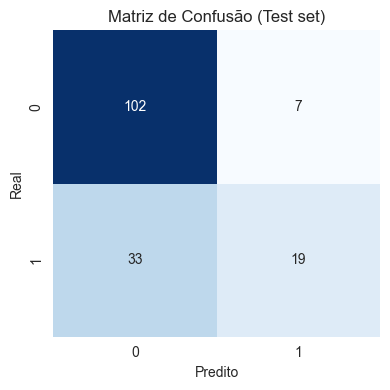

<Figure size 600x500 with 0 Axes>

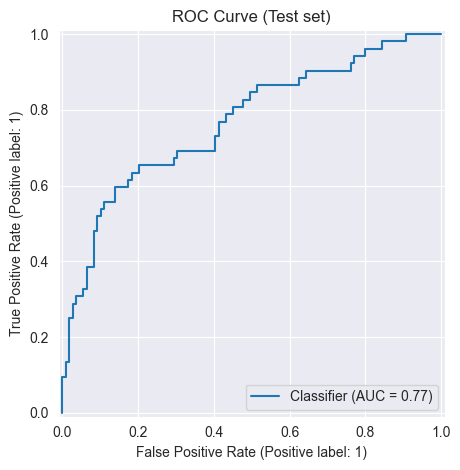

<Figure size 600x500 with 0 Axes>

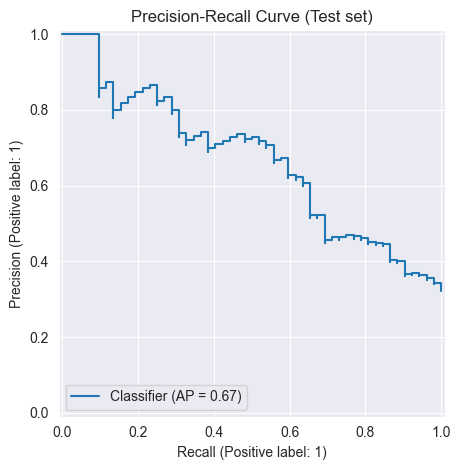

[CV] AUC-ROC (5-fold, predições por CV): 0.7708

Top características (Random Forest feature_importances_):
ENSG00000099985.4     0.003603
ENSG00000174564.13    0.003299
ENSG00000166415.15    0.002934
ENSG00000215440.12    0.002920
ENSG00000238246.1     0.002738
ENSG00000152779.14    0.002553
ENSG00000137825.11    0.002427
ENSG00000240303.8     0.002347
ENSG00000273437.1     0.002272
ENSG00000241112.1     0.002161
ENSG00000104213.13    0.002133
ENSG00000127329.16    0.002128
ENSG00000053328.8     0.002039
ENSG00000280366.1     0.001983
ENSG00000128965.13    0.001915
ENSG00000160182.3     0.001895
ENSG00000265800.1     0.001884
ENSG00000266970.1     0.001872
ENSG00000231948.2     0.001820
ENSG00000186212.4     0.001776
ENSG00000013573.17    0.001775
ENSG00000139572.4     0.001736
ENSG00000237181.1     0.001725
ENSG00000271778.1     0.001721
ENSG00000064886.14    0.001666
ENSG00000119411.11    0.001638
ENSG00000151623.15    0.001638
ENSG00000188859.7     0.001636
ENSG00000134285.11    0.0

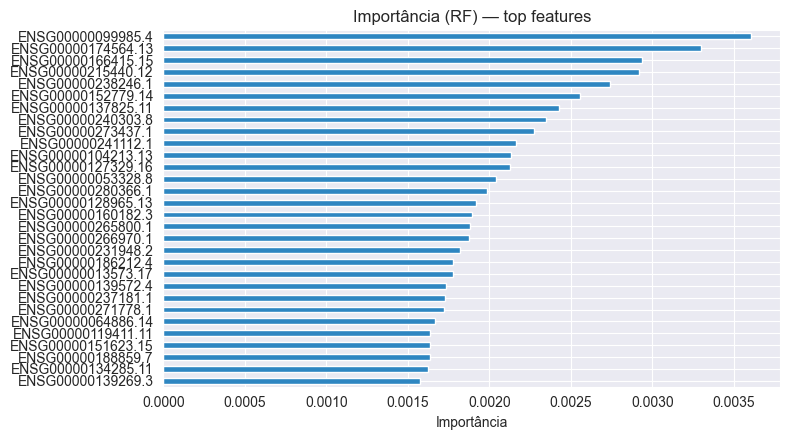

<Figure size 800x600 with 0 Axes>

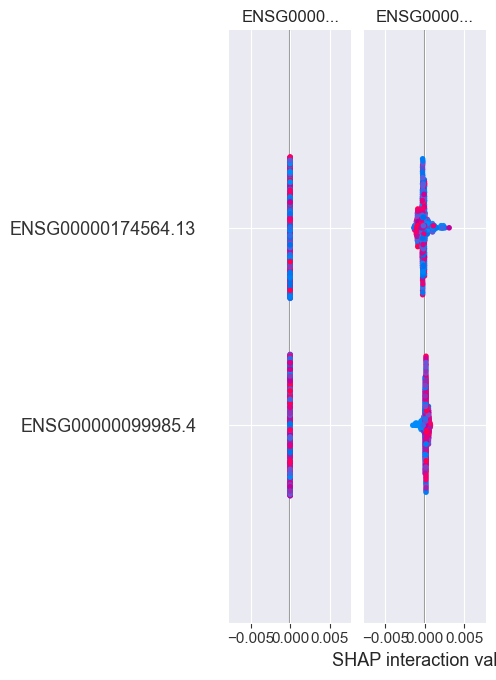

<Figure size 1000x800 with 0 Axes>

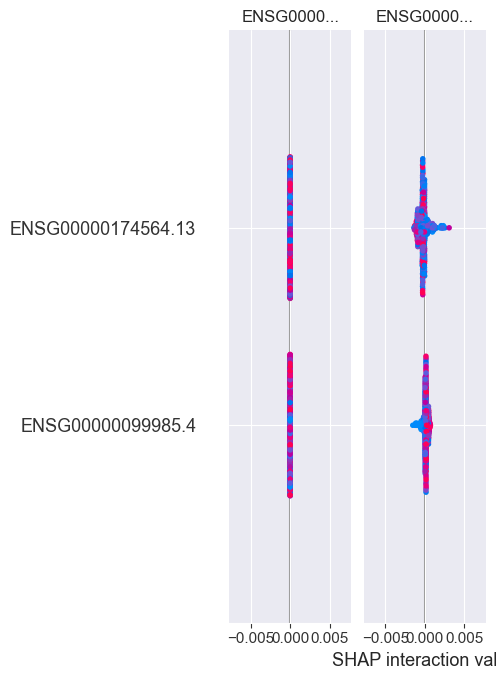


Top genes pelo SHAP (média absoluta) — top 20:
                  gene  mean_abs_shap
0    ENSG00000159387.8       0.002551
1    ENSG00000280306.1       0.002518
2   ENSG00000103522.16       0.002385
3    ENSG00000250451.5       0.002293
4    ENSG00000252272.1       0.002276
5    ENSG00000207631.1       0.002210
6    ENSG00000287099.1       0.002204
7    ENSG00000267461.1       0.002191
8   ENSG00000180061.10       0.002015
9   ENSG00000135917.16       0.002003
10   ENSG00000249047.2       0.001932
11   ENSG00000226002.1       0.001877
12  ENSG00000151023.17       0.001773
13  ENSG00000169248.13       0.001606
14  ENSG00000138411.13       0.001497
15  ENSG00000157335.21       0.001495
16  ENSG00000122691.13       0.001487
17   ENSG00000260911.2       0.001482
18   ENSG00000260565.7       0.001441
19  ENSG00000139908.15       0.001423


In [76]:
# df_final deve conter: colunas de metadados + genes
meta_cols = ['OS', 'gender.demographic'] 
output_prefix = "rf_pipeline"  
df = df_final.copy()

# separar metadados e genes
gene_cols = [c for c in df.columns if c not in meta_cols]
X = df[gene_cols].copy()
y = df['OS'].astype(int).copy()
print(f"Amostras: {X.shape[0]}, Genes (features): {X.shape[1]}")

# padronizar features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Treino/teste (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")

# Treinar Random Forest - usar class_weight='balanced' para lidar com desbalanceamento automaticamente
rf = RandomForestClassifier( n_estimators=500, max_depth=None, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

#  Avaliação no conjunto de teste
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan
cindex = concordance_index(y_test.values, y_prob)

print("\nAvaliação no conjunto de teste (70/30)")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"AUC-PR : {pr_auc:.4f}")
print(f"Acurácia: {acc:.4f}")
print(f"Sensibilidade (Recall): {recall:.4f}")
print(f"Especificidade: {specificity:.4f}")
print(f"C-Index: {cindex:.4f}")

# Matriz de confusão
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de Confusão (Test set)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.tight_layout()
plt.show()
plt.close()

# curvas ROC e PR 
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve (Test set)")
plt.tight_layout()
plt.show()
plt.close()

plt.figure(figsize=(6,5))
PrecisionRecallDisplay.from_predictions(y_test, y_prob)
plt.title("Precision-Recall Curve (Test set)")
plt.tight_layout()
plt.show()
plt.close()

# Validação cruzada estratificada (5-fold) — obter probabilidades por CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# cross_val_predict para probabilidades (classe positiva) em modo 'predict_proba'
y_prob_cv = cross_val_predict(rf, X_scaled, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

cv_auc = roc_auc_score(y, y_prob_cv)
print(f"[CV] AUC-ROC (5-fold, predições por CV): {cv_auc:.4f}")

# Importância global (Random Forest) 
feat_imp = pd.Series(rf.feature_importances_, index=gene_cols).sort_values(ascending=False)
topN = 30
print("\nTop características (Random Forest feature_importances_):")
print(feat_imp.head(topN))

plt.figure(figsize=(8, max(4, 0.15*topN)))
feat_imp.head(topN).sort_values().plot(kind='barh', color='#2E86C1')
plt.title("Importância (RF) — top features")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()
plt.close()

# Interpretabilidade com SHAP (TreeExplainer)
K_shap = 5793 
top_features_for_shap = feat_imp.head(K_shap).index.tolist()

# SHAP para Random Forest
X_shap = pd.DataFrame(X_scaled, columns=gene_cols)[top_features_for_shap]
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf(X_shap, check_additivity=False)

# compatibilizar formato para diferentes versões do SHAP
if isinstance(shap_values_rf, list):
    shap_vals_use = shap_values_rf[1]
elif hasattr(shap_values_rf, "values"):
    shap_vals_use = shap_values_rf.values
elif shap_values_rf.ndim == 3:
    shap_vals_use = shap_values_rf[:, :, 1]
else:
    shap_vals_use = shap_values_rf

# SHAP summary plots
plt.figure(figsize=(8,6))
shap.summary_plot(shap_vals_use, X_shap, plot_type="bar", show=True)
plt.close()

plt.figure(figsize=(10,8))
shap.summary_plot(shap_vals_use, X_shap, show=True)
plt.close()

# Garantir que o array seja 2D no formato [amostras, features]
shap_arr = shap_vals_use
if shap_arr.ndim == 3:
    shap_arr = shap_arr[:, :, 1]  # usa a classe positiva (ex: sobreviveu)
elif shap_arr.ndim == 1:
    shap_arr = shap_arr.reshape(-1, 1)

# Calcular importância média absoluta
mean_abs_shap = np.abs(shap_arr).mean(axis=0).ravel()  # garantir 1D

# Criar DataFrame de importância SHAP
shap_importance = pd.DataFrame({
    'gene': top_features_for_shap,
    'mean_abs_shap': mean_abs_shap
}).sort_values('mean_abs_shap', ascending=False).reset_index(drop=True)

print("\nTop genes pelo SHAP (média absoluta) — top 20:")
print(shap_importance.head(20))



Distribuição das predições do RF:
0    1.0
Name: proportion, dtype: float64

=== Regras da árvore substituta (GIRP-like, usando CLASSES) ===
|--- class: 0



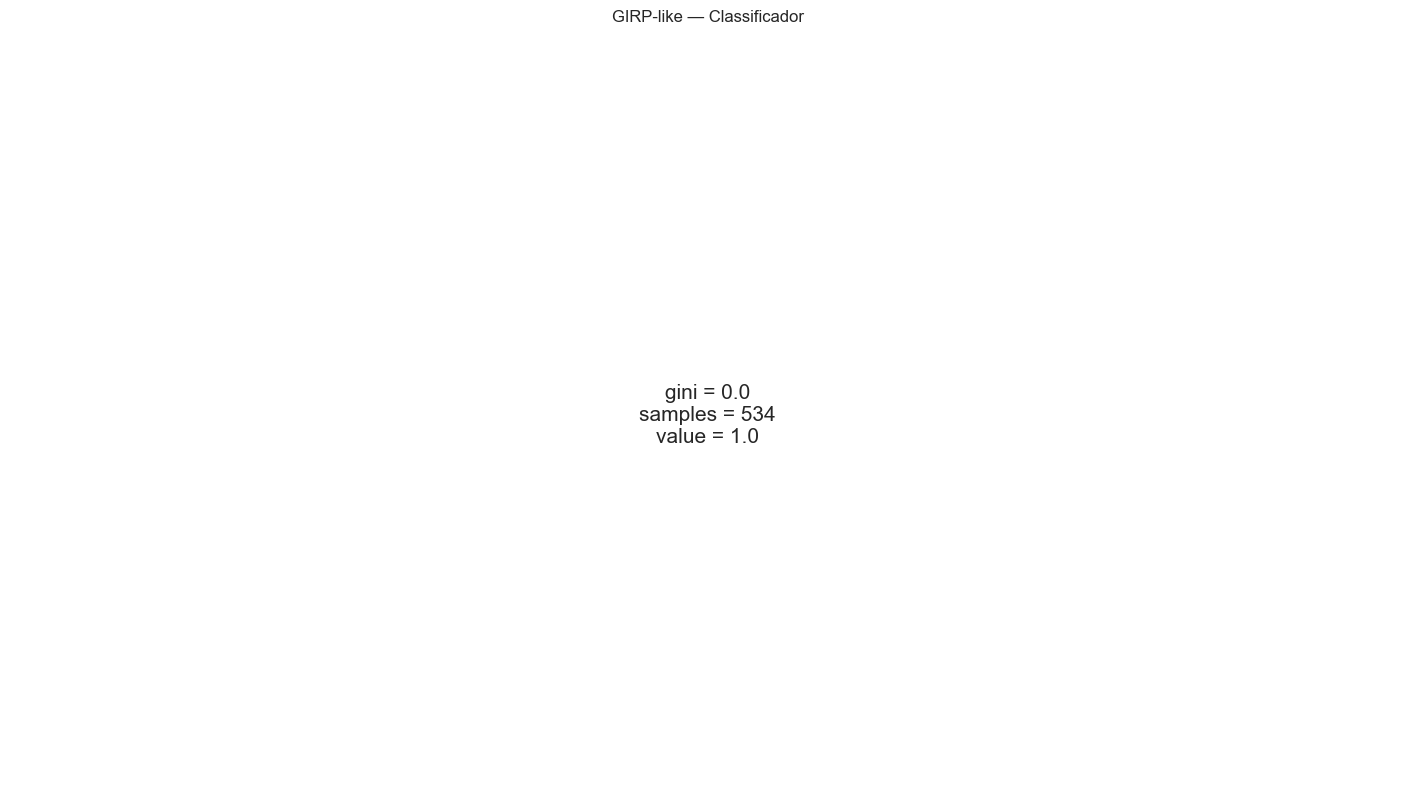


=== Regras da árvore substituta (GIRP-like, usando PROBABILIDADES) ===
|--- ENSG00000267523.1 <= -0.13
|   |--- ENSG00000219200.12 <= -0.97
|   |   |--- ENSG00000231233.1 <= -0.19
|   |   |   |--- ENSG00000213139.8 <= -1.26
|   |   |   |   |--- value: [0.30]
|   |   |   |--- ENSG00000213139.8 >  -1.26
|   |   |   |   |--- value: [0.32]
|   |   |--- ENSG00000231233.1 >  -0.19
|   |   |   |--- ENSG00000279799.1 <= -1.09
|   |   |   |   |--- value: [0.28]
|   |   |   |--- ENSG00000279799.1 >  -1.09
|   |   |   |   |--- value: [0.30]
|   |--- ENSG00000219200.12 >  -0.97
|   |   |--- ENSG00000197815.4 <= 0.12
|   |   |   |--- ENSG00000267541.1 <= -0.35
|   |   |   |   |--- value: [0.31]
|   |   |   |--- ENSG00000267541.1 >  -0.35
|   |   |   |   |--- value: [0.33]
|   |   |--- ENSG00000197815.4 >  0.12
|   |   |   |--- ENSG00000184613.11 <= -0.30
|   |   |   |   |--- value: [0.34]
|   |   |   |--- ENSG00000184613.11 >  -0.30
|   |   |   |   |--- value: [0.36]
|--- ENSG00000267523.1 >  -0.1

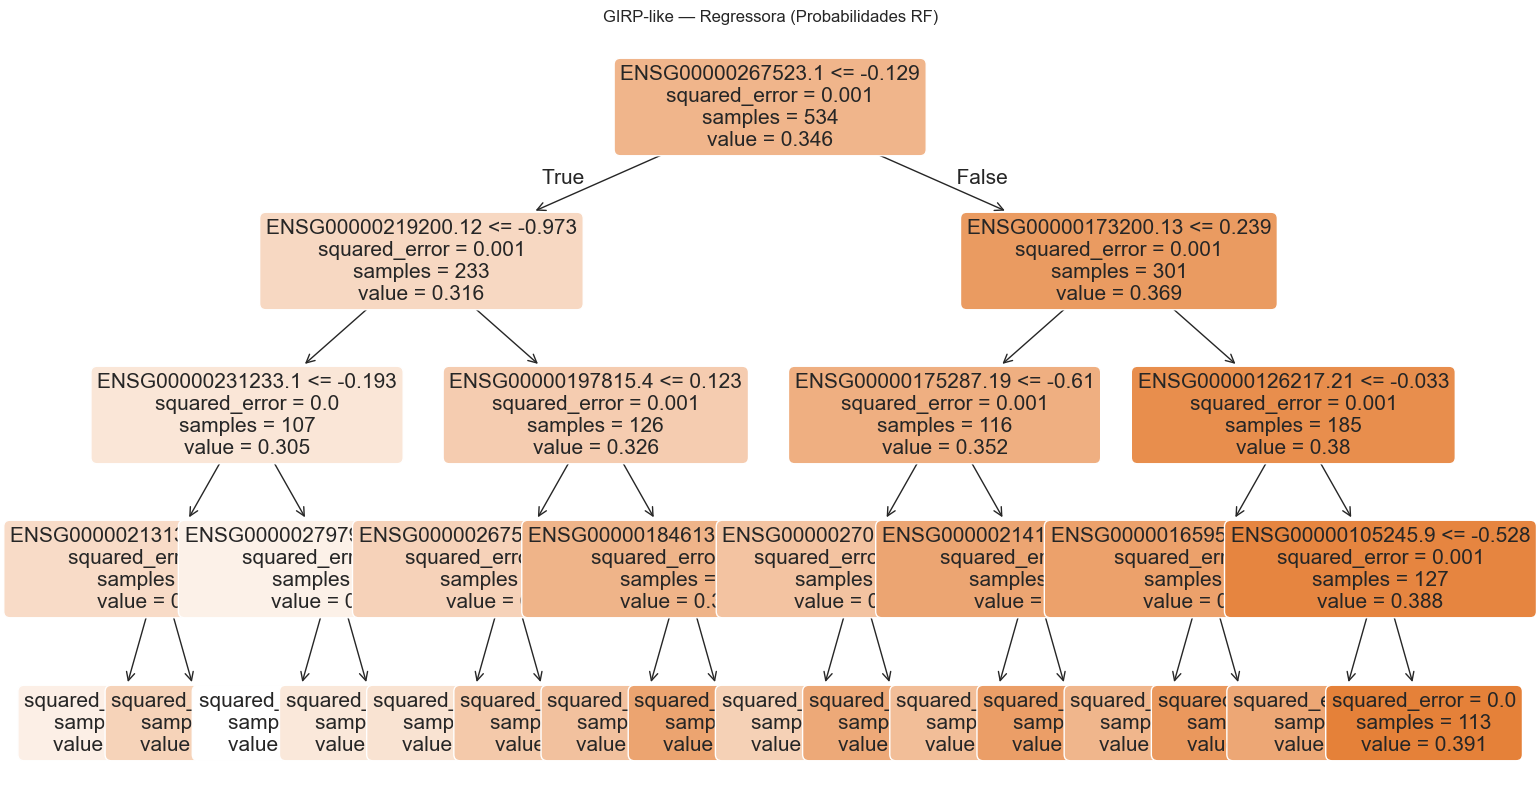

In [79]:
# GIRP-like - Random Forest

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text, plot_tree
from sklearn.tree._tree import TREE_LEAF
import matplotlib.pyplot as plt

# Selecionar apenas as features mais importantes (ex: top 50 do RF ou SHAP)
X_top = pd.DataFrame(X_scaled, columns=gene_cols)[top_features_for_shap]

# Predições do modelo Random Forest (classes e probabilidades)
rf_preds = rf.predict(X_top)
rf_probs = rf.predict_proba(X_top)[:, 1]

# Verificar o balanceamento das predições
class_counts = pd.Series(rf_preds).value_counts(normalize=True)
print("\nDistribuição das predições do RF:")
print(class_counts)

# Árvore substituta — versão CLASSIFICADORA
surrogate_clf = DecisionTreeClassifier( max_depth=4, min_samples_leaf=10, random_state=42)
surrogate_clf.fit(X_top, rf_preds)

rules_text_clf = export_text(surrogate_clf, feature_names=list(top_features_for_shap))
print("\n=== Regras da árvore substituta (GIRP-like, usando CLASSES) ===")
print(rules_text_clf if rules_text_clf.strip() else "Nenhuma regra gerada — modelo sem divisões informativas.")

# Visualização da árvore classificadora
plt.figure(figsize=(18, 10))
plot_tree(surrogate_clf, feature_names=list(top_features_for_shap), class_names=['Não sobreviveu (0)', 'Sobreviveu (1)'], filled=True, rounded=True, fontsize=15)
plt.title("GIRP-like — Classificador")
plt.show()
plt.close()

# Árvore substituta — versão REGRESSORA 
surrogate_reg = DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, random_state=42)
surrogate_reg.fit(X_top, rf_probs)

rules_text_reg = export_text(surrogate_reg, feature_names=list(top_features_for_shap))
print("\n=== Regras da árvore substituta (GIRP-like, usando PROBABILIDADES) ===")
print(rules_text_reg if rules_text_reg.strip() else "Nenhuma regra gerada — modelo sem divisões informativas.")

# Visualização da árvore regressora
plt.figure(figsize=(18, 10))
plot_tree(surrogate_reg, feature_names=list(top_features_for_shap), filled=True, rounded=True, fontsize=15)
plt.title("GIRP-like — Regressora (Probabilidades RF)")
plt.show()
plt.close()


In [84]:
# XGBoost Classifier
# ============================================================
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, average_precision_score
import shap

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("\n=== XGBoost - Teste ===")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"AUC-PR : {pr_auc:.4f}")
print(f"Acurácia: {acc:.4f}")
print(f"Sensibilidade: {recall:.4f}")
print(f"Especificidade: {specificity:.4f}")

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Matriz de confusão - XGBoost")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
plt.close()

# --- SHAP ---
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb(X_train, check_additivity=False)

plt.figure(figsize=(8,6))
shap.summary_plot(shap_values_xgb.values, pd.DataFrame(X_train, columns=gene_cols), plot_type="bar")
plt.title("XGBoost - SHAP Importância")
plt.show()
plt.close()


#Rede Neural Artificial (MLP)
# ============================================================
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Reutiliza X_scaled e y
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print("\n=== Rede Neural (MLP) - Teste ===")
print(f"AUC-ROC: {roc_auc:.4f}")
print(f"AUC-PR : {pr_auc:.4f}")
print(f"Acurácia: {acc:.4f}")
print(f"Sensibilidade: {recall:.4f}")
print(f"Especificidade: {specificity:.4f}")

plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title("Matriz de confusão - MLP")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()
plt.close()

# --- Validação cruzada ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_prob_cv = cross_val_predict(mlp, X_scaled, y, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
cv_auc = roc_auc_score(y, y_prob_cv)
print(f"[CV] AUC-ROC (MLP, 5-fold): {cv_auc:.4f}")

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/gracedossantosfeijo/PycharmProjects/TCCEspec_KIRC_KIRP/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <9A9D3D5C-89D9-31D9-9693-EB7151BDE349> /Users/gracedossantosfeijo/PycharmProjects/TCCEspec_KIRC_KIRP/.venv/lib/python3.10/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]
